In [ ]:
## Dataset: 1. F.-F. Li, M. Andreeto, M. Ranzato, P. Perona, Caltech 101 (2022)p. , doi:10.22002/D1.20086.

import tensorflow as tf # biblioteca principal usada para construir e treinar redes neurais
import tensorflow_datasets as tfds # ferramenta da própria equipe do TensorFlow que facilita o acesso a bases de dados famosas
import matplotlib.pyplot as plt # biblioteca usada para visualizar gráficos, como curvas de acurácia

(ds_train, ds_test), ds_info = tfds.load( # baixa e prepara o dataset automaticamente
    'caltech101', # nome do dataset a ser carregado
    split=['train[:80%]', 'train[80%:]'], # separa o conjunto em 80% para treino, 20% para teste
    shuffle_files=True, # embaralha os arquivos para não ter viés na ordem
    as_supervised=True, # retorna tuplas (imagem, rótulo) ao invés de dicionários
    with_info=True # retorna metadados do dataset (como o nome das classes)
)

print(ds_info.features['label'].names) # Mostra uma lista com os nomes das 101 classes (ex: 'camera', 'airplanes', etc.)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.P7QBFG_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.P7QBFG_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.
['accordion', 'airplanes', 'anchor', 'ant', 'background_google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'faces', 'faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 

In [ ]:
selected_classes = ['flamingo', 'pigeon'] # você define manualmente as duas classes que deseja usar pelo nome
class_names = ds_info.features['label'].names # lista com o nome de todas as classes do dataset
selected_ids = [class_names.index(name) for name in selected_classes] # obtém os índices numéricos correspondentes aos nomes selecionados (necessário para filtrar depois)

print("IDs selecionados:", selected_ids)

def filter_classes(image, label): # Função que será usada para filtrar apenas imagens cujos rótulos pertençam às duas classes escolhidas
    return tf.reduce_any([label == selected_ids[0], label == selected_ids[1]]) # retorna True se qualquer condição for verdadeira

def reencode_labels(image, label): # converter os rótulos para 0 ou 1 para facilitar o uso de classificação binária
    new_label = tf.cast(label == selected_ids[1], tf.int64) # e o rótulo for igual à segunda classe (ex: 'motorbikes'), ele vira 1; senão, 0
    return image, new_label

# Pré-processamento
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0 # define que todas as imagens terão tamanho 160x160 pixels
    return image, label

# Aplicar filtros e preparação
train_ds = ds_train.filter(filter_classes).map(reencode_labels).map(preprocess).batch(BATCH_SIZE).prefetch(1)
test_ds = ds_test.filter(filter_classes).map(reencode_labels).map(preprocess).batch(BATCH_SIZE).prefetch(1)
# BATCH_SIZE: número de imagens processadas por vez durante o treino
# prefetch: redimensiona cada imagem e normaliza os pixels (de 0 a 1)
# .filter(...): aplica a função de filtro para manter só as duas classes
# .map(...): aplica a conversão de rótulos e depois o pré-processamento
# .batch(BATCH_SIZE): agrupa imagens em lotes de 32
# .prefetch(1): melhora o desempenho carregando os dados enquanto o modelo treina

IDs selecionados: [40, 72]


In [ ]:
base_model = tf.keras.applications.MobileNetV2( # MobileNetV2: rede treinada com milhões de imagens (ImageNet)
    input_shape=IMG_SIZE + (3,), # precisa combinar com o tamanho das nossas imagens (160x160x3)
    include_top=False, # remove a “cabeça” original do modelo (classificador original)
    weights='imagenet' # carrega os pesos já treinados
)
base_model.trainable = False  # congela os pesos para usar como extrator de características fixo

# Adicionar as camadas finais
model = tf.keras.Sequential([ # cria uma pilha de camadas
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # resume cada mapa de ativação com uma média (reduz parâmetros)
    tf.keras.layers.Dense(1, activation='sigmoid')  # camada final com 1 saída para classificação binária
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # função de perda usada em classificações binárias
              metrics=['accuracy']) # acompanha a acurácia durante o treinamento

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit( # treina o modelo
    train_ds,
    validation_data=test_ds, # validação com dados que o modelo nunca viu
    epochs=5 # faz 5 passagens completas pelos dados
)

Epoch 1/5
      2/Unknown 9s 468ms/step - accuracy: 0.7530 - loss: 0.5749

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7644 - loss: 0.5707 - val_accuracy: 0.6923 - val_loss: 0.5462
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.9120 - loss: 0.4210 - val_accuracy: 0.8462 - val_loss: 0.4336
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - accuracy: 0.9612 - loss: 0.3184 - val_accuracy: 1.0000 - val_loss: 0.3427
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - accuracy: 0.9754 - loss: 0.2397 - val_accuracy: 1.0000 - val_loss: 0.2700
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - accuracy: 1.0000 - loss: 0.1802 - val_accuracy: 1.0000 - val_loss: 0.2131


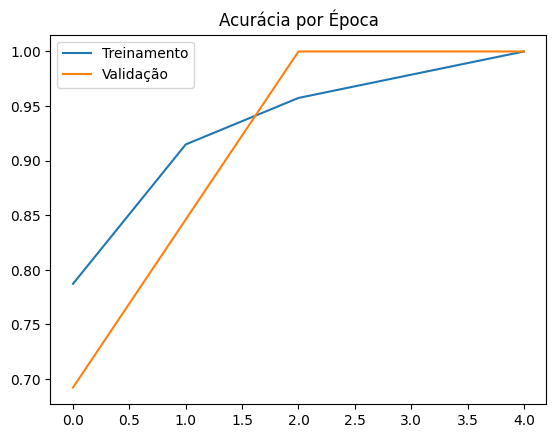

In [ ]:
# Ajuda a ver se o modelo está aprendendo ou sofrendo overfitting
acc = history.history['accuracy'] # contém os registros da acurácia a cada época
val_acc = history.history['val_accuracy'] # desenha os gráficos para comparar treino vs. validação

plt.plot(acc, label='Treinamento')
plt.plot(val_acc, label='Validação')
plt.legend()
plt.title("Acurácia por Época")
plt.show()

In [9]:
model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 1.0000 - loss: 0.2131


[0.21311615407466888, 1.0]